## NOT FUNCTIONAL CODE DON'T USE ME

simply a trial for how to do VR_viz_homGroupsColored_2.0.ipynb so use that file

Author: @emilyekstrum
<br> 11/17/25

In [ ]:

"""
Vietoris–Rips Filtration Visualization Colored by Homology Group 

"""

import numpy as np
import matplotlib.pyplot as plt
from ripser import ripser
import matplotlib.patches as mpatches
import pickle as pkl

def load_embedding_data(filepath):
    """Loads in embedding stored in pickle file
    See CEBRA.ipynb or PCA_UMAP.ipynb for details how embeddings are stored in pickle."""
    with open(filepath, "rb") as f:
        single_session_dict = pkl.load(f)
        session_names = list(single_session_dict.keys())
        
    return single_session_dict, session_names

def edge_color_from_betti(b0, b1, b2):
    """Assign edge color based on homology presence."""
    if b2 > 0:
        return "tab:green"
    if b1 > 0:
        return "tab:orange"
    if b0 > 0:
        return "tab:blue"
    return "0.5"  # gray


def _betti_at_t(intervals, t):
    """Compute Betti(t): number of features alive at filtration value t."""
    if intervals is None or len(intervals) == 0:
        return 0
    births = intervals[:, 0]
    deaths = intervals[:, 1]
    alive = (births <= t) & ((deaths > t) | np.isinf(deaths))
    return int(np.count_nonzero(alive))


def downsample_embedding(embedding, n_samples=None, sampling_method='random'):
    """Downsample points for faster visualization."""
    n_points = len(embedding)
    if n_samples is None:
        n_samples = min(500, max(50, int(0.1 * n_points)))
    if n_samples >= n_points:
        return embedding, list(range(n_points))

    if sampling_method == 'random':
        indices = np.random.choice(n_points, size=n_samples, replace=False)
    elif sampling_method == 'uniform':
        indices = np.linspace(0, n_points - 1, n_samples, dtype=int)
    elif sampling_method == 'first':
        indices = np.arange(n_samples)
    else:
        raise ValueError("sampling_method must be 'random', 'uniform', or 'first'")

    indices = np.sort(indices)
    return embedding[indices], indices.tolist()


def increase_ball_epsilon(embedding, diameter):
    """
    Create Euclidean balls of radius = diameter/2 and connect overlapping pairs.
    Compute Betti nums at this filtration diameter using Ripser.
    """
    epsilon = diameter / 2.0
    n_points = len(embedding)

    balls = {i: {'center': embedding[i], 'radius': epsilon, 'center_idx': i}
             for i in range(n_points)}

    # Pairwise overlaps
    connections = []
    for i in range(n_points):
        pi = embedding[i]
        for j in range(i + 1, n_points):
            pj = embedding[j]
            if np.linalg.norm(pi - pj) <= diameter:
                connections.append((i, j))

    dgms = ripser(embedding, maxdim=2, thresh=diameter)["dgms"]
    betti0 = _betti_at_t(dgms[0], diameter) if len(dgms) > 0 else 0
    betti1 = _betti_at_t(dgms[1], diameter) if len(dgms) > 1 else 0
    betti2 = _betti_at_t(dgms[2], diameter) if len(dgms) > 2 else 0

    return {
        'balls': balls,
        'connections': connections,
        'epsilon': epsilon,
        'diameter': diameter,
        'num_connections': len(connections),
        'betti0': betti0,
        'betti1': betti1,
        'betti2': betti2
    }


def create_3d_sphere(ax, center, radius, color='lightblue', alpha=0.08):
    """Render a translucent 3D sphere at given center."""
    u = np.linspace(0, 2 * np.pi, 20)
    v = np.linspace(0, np.pi, 20)
    x = center[0] + radius * np.outer(np.cos(u), np.sin(v))
    y = center[1] + radius * np.outer(np.sin(u), np.sin(v))
    z = center[2] + radius * np.outer(np.ones(np.size(u)), np.cos(v))
    ax.plot_surface(x, y, z, color=color, alpha=alpha,
                    linewidth=0.3, edgecolor='blue', zorder=1)


def demonstrate_filtration_progression(embedding, diameter_range, n_steps=5, show_spheres=True):
    """
    Visualize the Vietoris–Rips filtration in 3D.
    Edge colors indicate which homology group exists at each diameter.
    """
    min_d, max_d = diameter_range
    diameters = np.linspace(min_d, max_d, n_steps)

    if embedding.shape[1] == 2:
        embedding_3d = np.column_stack([embedding, np.zeros(len(embedding))])
        print("Note: Converting 2D embedding to 3D for visualization (z=0)")
    elif embedding.shape[1] >= 3:
        embedding_3d = embedding[:, :3]
        if embedding.shape[1] > 3:
            print(f"Note: Using first 3 dimensions from {embedding.shape[1]}D embedding")
    else:
        raise ValueError("Embedding must have at least 2 dimensions")

    rows = 2
    cols = int(np.ceil(n_steps / rows))
    fig = plt.figure(figsize=(5 * cols, 10))

    for i, d in enumerate(diameters):
        res = increase_ball_epsilon(embedding_3d, d)
        ax = fig.add_subplot(rows, cols, i + 1, projection='3d')

        # Scatter points
        centers = np.array([b['center'] for b in res['balls'].values()])
        ax.scatter(centers[:, 0], centers[:, 1], centers[:, 2],
                   c='red', s=6, alpha=0.9, edgecolors='darkred', linewidth=0.4)

        # Optional spheres
        if show_spheres:
            for b in res['balls'].values():
                create_3d_sphere(ax, b['center'], b['radius'])

        # Colored connections
        edge_c = edge_color_from_betti(res['betti0'], res['betti1'], res['betti2'])
        for (j, k) in res['connections']:
            p1 = res['balls'][j]['center']
            p2 = res['balls'][k]['center']
            ax.plot([p1[0], p2[0]], [p1[1], p2[1]], [p1[2], p2[2]],
                    alpha=0.9, linewidth=1.4, c=edge_c, zorder=2)

        ax.set_title(f"d={d:.3f} \nβ₀={res['betti0']}  β₁={res['betti1']}  β₂={res['betti2']}",
                     fontsize=11, pad=6)
        ax.set_xlabel('Dim 1')
        ax.set_ylabel('Dim 2')
        ax.set_zlabel('Dim 3')
        ax.set_box_aspect([1, 1, 1])
        ax.grid(True, alpha=0.3)
        ax.view_init(elev=20, azim=45)

    legend_patches = [
        mpatches.Patch(color="tab:blue",   label=r"β₀"),
        mpatches.Patch(color="tab:orange", label=r"β₁"),
        mpatches.Patch(color="tab:green",  label=r"β₂"),
        mpatches.Patch(color="0.5",        label="no homology"),
    ]
    fig.legend(handles=legend_patches, loc="upper center", ncol=4, frameon=False)

    plt.suptitle('Vietoris–Rips Filtration Progression',
                 fontsize=15, fontweight='bold')
    plt.tight_layout()
    plt.show()


def test_embedding_filtration_workflow(embedding_dict, mouse_name,
                                       n_samples=200, diameter_range=(0.05, 0.3),
                                       n_filtration_steps=5, sampling_method='random'):

    print(f"Vietoris–Rips Filtration Visualization")
    print(f"Mouse/Session: {mouse_name}")

    if mouse_name not in embedding_dict:
        raise ValueError(f"Mouse '{mouse_name}' not found. Available: {list(embedding_dict.keys())}")

    original_embedding = embedding_dict[mouse_name]["embedding"]
    print(f"Original embedding shape: {original_embedding.shape}")

    downsampled_embedding, selected_indices = downsample_embedding(
        original_embedding, n_samples=n_samples, sampling_method=sampling_method
    )
    print(f"Downsampled to {len(downsampled_embedding)} points.")

    demonstrate_filtration_progression(downsampled_embedding, diameter_range, n_steps=n_filtration_steps)

    return {
        'original_embedding': original_embedding,
        'downsampled_embedding': downsampled_embedding,
        'selected_indices': selected_indices
    }



Vietoris–Rips Filtration Visualization
Mouse/Session: C159
Original embedding shape: (150, 3)
Downsampled to 80 points.


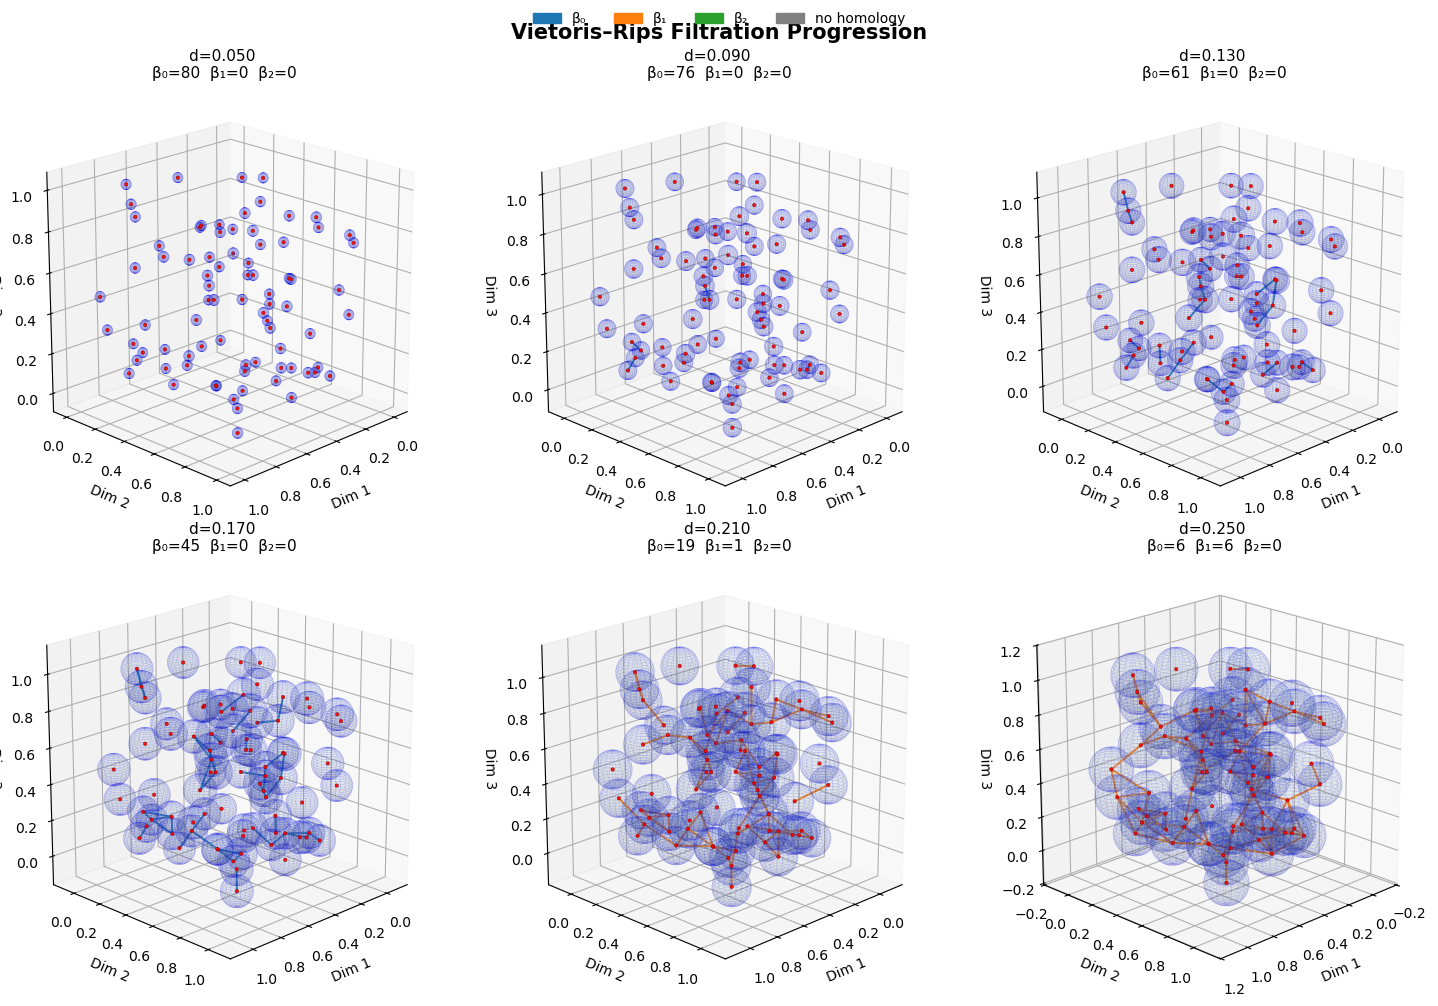

In [11]:


if __name__ == "__main__":
    np.random.seed(42)
    embedding_dict = {"C159": {"embedding": np.random.rand(150, 3)}}
    test_embedding_filtration_workflow(embedding_dict, "C159",
                                       n_samples=80,
                                       diameter_range=(0.05, 0.25),
                                       n_filtration_steps=6)


In [6]:
filepath = r"C:\Users\denmanlab\Desktop\Emily_rotation\CEBRA\3d\raw\LGN_3d_CEBRA_unsup_time_chromatic_gratings.pkl"
embedding, names = load_embedding_data(filepath)

c:\Users\denmanlab\.conda\envs\topology\Lib\site-packages\requests\__init__.py:86: RequestsDependencyWarning: Unable to find acceptable character detection dependency (chardet or charset_normalizer).
  warnings.warn(
